In [754]:
from __future__ import print_function

In [803]:
# imports
from bs4 import BeautifulSoup
import requests

import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
import nltk
import textstat
from textblob import TextBlob
import pyLDAvis
import pyLDAvis.sklearn
from mpl_toolkits import mplot3d
import pandas as pd
from pprint import pprint
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk.corpus import stopwords

In [ ]:
nltk.download('averaged_perceptron_tagger')

# Data Gathering

In [144]:
# figuring out scraping
base_url = 'http://www.emersonkent.com/famous_speeches_in_history_topic.htm'
response = requests.get(base_url)
page = response.text
soup = BeautifulSoup(page, 'lxml')


In [82]:
print(soup.prettify())

<html>
 <head>
  <title>
   Famous Speeches in History - By Speech Topic: P - S
  </title>
  <meta content="Famous speeches in history, indexed by title of speech, A - Z. This page lists speech topics from the letter P to S." name="Description"/>
  <meta content="speeches in history,famous speeches,famous speakers,history,gettysburg address,i have a dream speech,finest hour,adolf hitler's,ronald reagan's" name="Keywords"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script async="" src="//pagead2.googlesyndication.com/pagead/js/adsbygoogle.js">
  </script>
  <script>
   (adsbygoogle = window.adsbygoogle || []).push({
    google_ad_client: "ca-pub-8680821756854668",
    enable_page_level_ads: true
  });
  </script>
 </head>
 <body bgcolor="#D4D9DD" bottommargin="0" leftmargin="0" rightmargin="0" style="background-attachment: fixed" topmargin="0">
  <div align="center">
   <table background="images/bg.gif" border="0" cellpadding="0" id="table1" style="border

In [83]:
# getting urls for individual speeches
for element in soup.find(id='table6').find_all(style='text-decoration: none'):
    link = str(element).split()[1].split('=')[1]
    if link.split('/')[0] == '"speeches':
        print(link)

"speeches/paris_liberated.htm"
"speeches/paris_libere.htm"
"speeches/patria_o_muerte.htm"
"speeches/peace_in_our_time.htm"
"speeches/perils_of_indifference.htm"
"speeches/plymouth_oration.htm"
"speeches/politics_as_an_art.htm"
"speeches/proclamation_to_the_german_nation_intro_goebbels.htm"
"speeches/proclamation_to_the_german_nation.htm"
"speeches/quarantine_the_aggressor.htm"
"speeches/quit_india.htm"
"speeches/resignation_speech.htm"
"speeches/resignation_speech_nixon.htm"
"speeches/resignation_speech_howe.htm"
"speeches/returning_fire.htm"
"speeches/rivers_of_blood.htm"
"speeches/sanitas_sanitatum_omnia_sanitas.htm"
"speeches/school_house_door_speech.htm"
"speeches/segregation_forever.htm"
"speeches/sermon_on_the_mound.htm"
"speeches/sermon_on_the_mount.htm"
"speeches/sermon_to_the_birds.htm"
"speeches/share_the_wealth.htm"
"speeches/sinners_in_the_hands_of_an_angry_god.htm"
"speeches/social_security.htm"
"speeches/solitude_of_self.htm"
"speeches/spanish_armada_speech.htm"
"speeches

In [ ]:
# manually make a list of urls of speeches sorted alphabetically by topics
#soup.find('blockquote')
topic_links_list = ['http://www.emersonkent.com/famous_speeches_in_history_topic.htm',
                    'famous_speeches_in_history_topic_from_b.htm',
                    'famous_speeches_in_history_topic_from_e.htm',
                    'famous_speeches_in_history_topic_from_h.htm',
                    'famous_speeches_in_history_topic_from_j.htm',
                    'famous_speeches_in_history_topic_from_p.htm',
                    'famous_speeches_in_history_topic_from_t.htm',
                    'famous_speeches_in_history_topic_from_the_k.htm',
                    'famous_speeches_in_history_topic_from_u.htm']

In [453]:
# getting text from a speech page
speech_url = 'http://www.emersonkent.com/' + 'speeches/you_ve_got_to_find_what_you_love.htm'
response = requests.get(speech_url)
speech_page = response.text
speech_soup = BeautifulSoup(speech_page, 'lxml')

In [111]:
print(speech_soup.prettify())

<html>
 <head>
  <title>
   9/11 Address - George W. Bush 2001
  </title>
  <meta content="Full text transcript of George W. Bush's 9/11 Address, delivered from the Oval Office, Washington, D.C. - September 11, 2001" name="Description"/>
  <meta content="bush,george w,speech,september 11,history" name="Keywords"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <script async="" src="//pagead2.googlesyndication.com/pagead/js/adsbygoogle.js">
  </script>
  <script>
   (adsbygoogle = window.adsbygoogle || []).push({
    google_ad_client: "ca-pub-8680821756854668",
    enable_page_level_ads: true
  });
  </script>
 </head>
 <body bgcolor="#D4D9DD" bottommargin="0" leftmargin="0" rightmargin="0" style="background-attachment: fixed" topmargin="0">
  <div align="center">
   <table background="../images/bg.gif" border="0" cellpadding="0" id="table1" style="border-collapse: collapse" width="1014">
    <tr>
     <td valign="top">
      <div align="center">
       <table 

In [749]:
edited_sentence = ''
for block in speech_soup.find_all(align='left', style='margin-left: 20px; margin-right: 20px'):
    full_text = block.text
    stripped_text = block.text.encode('ascii','ignore').decode('ascii').strip().replace('\n','').replace('\t','').replace('\r','').split()
    tagged_sentence = nltk.tag.pos_tag(stripped_text)
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
#print(' '.join(edited_sentence))
#    if(len(block.text.strip()) > 10):
       # speech_text += block.text.strip()

In [414]:
#speech_soup.find_all(face='Verdana', size='2')[12]
speech_text = ''
#speech_soup.find_all(align='left', style='margin-left: 20px; margin-right: 20px')[0]
for block in speech_soup.find_all(align='left', style='margin-left: 20px; margin-right: 20px'):
    if(len(block.text.strip()) > 10):
        speech_text += block.text.strip()
        print(speech_text)
#speech_text = speech_text.replace('\t', '').replace('\r','').replace('\n','')
#speech_text

HOME   -   





FAMOUS SPEECHES IN 
									HISTORY   -   
									ADDRESS TO THE U.N. 
									GENERAL ASSEMBLY
HOME   -   





FAMOUS SPEECHES IN 
									HISTORY   -   
									ADDRESS TO THE U.N. 
									GENERAL ASSEMBLYAddress to the U.N. General Assembly
HOME   -   





FAMOUS SPEECHES IN 
									HISTORY   -   
									ADDRESS TO THE U.N. 
									GENERAL ASSEMBLYAddress to the U.N. General AssemblyAs I begin my 
								address to this Assembly, I would like first of 
								all to express to you, Mr President, my sincere 
								gratitude for your kind words. My thanks go also 
								to the Secretary-General, Mr Ban Ki-moon, for 
								inviting me to visit the headquarters of this 
								Organization and for the welcome that he has 
								extended to me. I greet the Ambassadors and 
								Diplomats from the Member States, and all those 
								present. Through you, I greet the peoples who 
								are represented here. They look to this 
								insti

In [676]:
# scrape all speeches
topic_links_list = ['famous_speeches_in_history_topic.htm',
                    'famous_speeches_in_history_topic_from_b.htm',
                    'famous_speeches_in_history_topic_from_e.htm',
                    'famous_speeches_in_history_topic_from_h.htm',
                    'famous_speeches_in_history_topic_from_j.htm',
                    'famous_speeches_in_history_topic_from_p.htm',
                    'famous_speeches_in_history_topic_from_t.htm',
                    'famous_speeches_in_history_topic_from_the_k.htm',
                    'famous_speeches_in_history_topic_from_u.htm']
base_url = 'http://www.emersonkent.com/'
def scraping():
    count = 0
    speeches_list = []
    # go through each page with a list of speeches
    for topic in topic_links_list:
        # get urls in beautifulsoup
        speech_index_url = base_url + topic
        response = requests.get(speech_index_url)
        speech_index_page = response.text
        speech_index_soup = BeautifulSoup(speech_index_page, 'lxml')
        
        # get list of speeches on the page
        speech_url_list = []
        for speech_link in speech_index_soup.find(id='table6').find_all(style='text-decoration: none'):
            link = str(speech_link).split()[1].split('=')[1].replace('"', '')
            if link.split('/')[0] == 'speeches':
                speech_url_list.append(link)

            
        # get text from each speech page
        for speech_link in speech_url_list:
            speech_url = base_url + speech_link
            print(speech_url)
            print(count)
            count+=1
            response = requests.get(speech_url)
            speech_page = response.text
            speech_soup = BeautifulSoup(speech_page, 'lxml')
            speech_text = '' # used to collect all text as a string in earlier versions
            speech_text_word_list = []
            tagged_sentence = []
            for text_block in speech_soup.find_all(align='left', style='margin-left: 20px; margin-right: 20px'):
                #print('text stripped: ' + str(len(text_block.text.strip())))
                if(len(text_block.text.strip()) > 20):
                    speech_text = text_block.text.strip().replace('\n','').replace('\t','').replace('\r','')
                    speech_text_encoded = speech_text.encode('ascii','ignore').decode('ascii')
                    #print(speech_text_encoded)
                    speech_text_word_list = speech_text_encoded.split()
                    tagged_sentence.extend(nltk.tag.pos_tag(speech_text_word_list))
            #for w in tagged_sentence:
            #    print(w)
            edited_sentence = [word for word,tag in tagged_sentence if tag == 'NNP' or tag == 'NNPS' 
                                                                    or tag == 'NN' or tag == 'NNS']
            #print('speech text'+ speech_text)
#             print('speech text word list: ')
#             for e in speech_text_word_list:
#                 print(e)
            #print('edited sentence: ')
            #for e in edited_sentence:
                #print(e)
            if(len(speech_text)-len(speech_text_encoded) > 30):
                print('dropped this speech')
                speeches_list.append('')
            else:
                speeches_list.append(' '.join(edited_sentence))
    return speeches_list

speeches_only_nouns = scraping()
# remove list (without encode/regular diffs)= [27,32,38,49,66,67,76,77,83,95,111,124,158,159,160,170,]
# add list (with encode/regular diffs > 50) = [8,25,80,166,202,225]
# drop '' = [32,66,124,]

http://www.emersonkent.com/speeches/9_11_address.htm
0
http://www.emersonkent.com/speeches/a_house_divided.htm
1
http://www.emersonkent.com/speeches/a_time_for_choosing.htm
2
http://www.emersonkent.com/speeches/a_time_to_break_silence.htm
3
http://www.emersonkent.com/speeches/a_tryst_with_destiny.htm
4
http://www.emersonkent.com/speeches/a_whisper_of_aids.htm
5
http://www.emersonkent.com/speeches/abdication_edward_viii.htm
6
http://www.emersonkent.com/speeches/abolition.htm
7
http://www.emersonkent.com/speeches/acres_of_diamonds.htm
8
http://www.emersonkent.com/speeches/action_rather_than_speech.htm
9
http://www.emersonkent.com/speeches/address_challenger_disaster.htm
10
http://www.emersonkent.com/speeches/address_on_the_release_from_prison.htm
11
http://www.emersonkent.com/speeches/address_to_the_american_equal_rights_association.htm
12
http://www.emersonkent.com/speeches/address_to_british_parliament.htm
13
http://www.emersonkent.com/speeches/address_federal_convention_franklin.htm
1

http://www.emersonkent.com/speeches/ich_bin_ein_berliner.htm
123
http://www.emersonkent.com/speeches/in_catilinam_i.htm
124
http://www.emersonkent.com/speeches/inaugural_address_first_washington.htm
125
http://www.emersonkent.com/speeches/inaugural_address_adams.htm
126
http://www.emersonkent.com/speeches/inaugural_address_first_jefferson.htm
127
http://www.emersonkent.com/speeches/inaugural_address_first_jackson.htm
128
http://www.emersonkent.com/speeches/inaugural_address_second_jackson.htm
129
http://www.emersonkent.com/speeches/inaugural_address_first_lincoln.htm
130
http://www.emersonkent.com/speeches/inaugural_address_second_lincoln.htm
131
http://www.emersonkent.com/speeches/inaugural_address_teddy_roosevelt.htm
132
http://www.emersonkent.com/speeches/the_only_thing_we_have_to_fear_is_fear_itself.htm
133
http://www.emersonkent.com/speeches/inaugural_address_second_fdr.htm
134
http://www.emersonkent.com/speeches/inaugural_address_third_fdr.htm
135
http://www.emersonkent.com/speec

http://www.emersonkent.com/speeches/the_english_tradition.htm
243
http://www.emersonkent.com/speeches/the_evil_empire.htm
244
http://www.emersonkent.com/speeches/the_few.htm
245
http://www.emersonkent.com/speeches/flame_of_the_french_resistance.htm
246
http://www.emersonkent.com/speeches/the_forgotten_people.htm
247
http://www.emersonkent.com/speeches/the_four_freedoms.htm
248
http://www.emersonkent.com/speeches/the_fourteen_points.htm
249
http://www.emersonkent.com/speeches/the_fundamental_principle_of_a_republic.htm
250
http://www.emersonkent.com/speeches/the_great_silent_majority.htm
251
http://www.emersonkent.com/speeches/the_great_society.htm
252
http://www.emersonkent.com/speeches/the_hypocrisy_of_american_slavery.htm
253
http://www.emersonkent.com/speeches/the_jewish_question.htm
254
http://www.emersonkent.com/speeches/the_lady_s_not_for_turning.htm
255
http://www.emersonkent.com/speeches/the_law_of_love.htm
256
http://www.emersonkent.com/speeches/the_liberation_of_kuwait.htm
25

In [655]:
speeches_no_proper_nouns = speeches_raw_no_nouns

In [470]:
for idx, speech in enumerate(speeches_raw_no_nouns):
    if(speech == ''):
        print(idx)
    

157


In [471]:
speeches_raw_no_nouns.pop(157)

''

In [552]:
for speech in speeches_raw_no_nouns[-5:]:
    print(speech + '\n\n')

- - WRATH OF Wrath of It follows the full text transcript of of speech, delivered at various times and place from 1986. Because I believe our greatest court, the court of last resort, is the American people. And I believe that once you have taken a few moments to hear this message you will concur in this verdict along with a million other who are already committed to the largest grape boycott in history. The worth of humans is involved here. I see us as one family. We cannot turn our backs on each other and our future. We farm workers are closest to food production. We were the first to recognize the serious health hazards of agriculture pesticides to both consumers and ourselves. Twenty years ago over 17 million united in a grape boycott campaign that transformed the simple act of refusing to buy grapes into a powerful and effective force against poverty and injustice. Through the combined strengths of a national boycott, farm workers won many of the same rights as other workers--the 

In [179]:
# cleaning speeches
speech_url = 'http://www.emersonkent.com/' + 'speeches/you_ve_got_to_find_what_you_love.htm'
response = requests.get(speech_url)
speech_page = response.text
speech_soup = BeautifulSoup(speech_page, 'lxml')
speech_text = ''
for block in speech_soup.find_all(align='left', style='margin-left: 20px; margin-right: 20px')[1:]:
    speech_text += block.text.replace('\t', '').replace('\r','').replace('\n','')
speeches.append(speech_text)
speech_text = ''

In [226]:
speech_url = 'http://www.emersonkent.com/' + 'speeches/address_to_the_un_general_assembly_benedict.htm'
response = requests.get(speech_url)
speech_page = response.text
speech_soup = BeautifulSoup(speech_page, 'lxml')
speech_text = ''
for block in speech_soup.find_all(align='left', style='margin-left: 20px; margin-right: 20px')[2:-2]:
    speech_text += block.text.replace('\t', '').replace('\r','').replace('\n','')
speeches[25] = speech_text
speech_text = ''

In [288]:
# test cleaned speeches
empty = 0
empty_inds = []
for ind, speech in enumerate(speeches):
    if(speech == ''):
        empty += 1
        empty_inds.append(ind)
#print(empty, empty_inds)
### list for popping: a few around 25, roughly 47, a few around earlier 20s, ~64 & 65, ~75 & 76 and one more ~5 further,
### ~88, ~103 
speeches[102]

'In the field of world policy I would dedicate this nation to the policy of the good neighbor--the neighbor who resolutely respects himself and, because he does so, respects the rights of others--the neighbor who respects his obligations and respects the sanctity of his agreements in and with a world of neighbors.'

In [839]:
# save speeches
with open('pickles/speeches.pkl', 'wb') as f:
       pickle.dump(speeches, f)

In [840]:
with open('pickles/speeches_raw.pkl', 'wb') as f:
       pickle.dump(speeches_raw, f)

In [841]:
with open('pickles/speeches_no_proper_nouns.pkl', 'wb') as f:
       pickle.dump(speeches_no_proper_nouns, f)

In [842]:
with open('pickles/speeches_no_nouns.pkl', 'wb') as f:
       pickle.dump(speeches_no_nouns, f)

In [843]:
with open('pickles/speeches_only_nouns.pkl', 'wb') as f:
       pickle.dump(speeches_only_nouns, f)

# Data modeling

vectorizing

In [766]:
# tf idf
tfvectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
Xtf = tfvectorizer.fit_transform(speeches_only_nouns)
print(tfvectorizer.get_feature_names())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [762]:
# count vectorizer
cvectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3))
Xc = cvectorizer.fit_transform(speeches_only_nouns)
print(cvectorizer.get_feature_names())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



dimension reducing

In [740]:
# tf idf lsa
tvsvd = TruncatedSVD(n_components=10, random_state=408)
normalizer = Normalizer(copy=False)
tvlsa = make_pipeline(tvsvd, normalizer)
#tvsvd.fit_transform(Xtf)
Xtvlsa = tvlsa.fit_transform(Xtf)

In [741]:
# countvec lsa
cvsvd = TruncatedSVD(n_components=10, random_state=493)
normalizer = Normalizer(copy=False)
cvlsa = make_pipeline(cvsvd, normalizer)
Xcvlsa = cvlsa.fit_transform(Xc)

In [767]:
# countvec lda
cvlda = LatentDirichletAllocation(n_components=10, random_state=493)
cvlda.fit(Xc)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=493, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [768]:
tvlda = LatentDirichletAllocation(n_components=10, random_state=408)
tvlda.fit(Xtf)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=408, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [695]:
# tf idf nmf
tvnmf = NMF(n_components=10, random_state=408)
Xtvnmf = tvnmf.fit_transform(Xtf)

In [696]:
# countvec nmf
cvnmf = NMF(n_components=10, random_state=493)
Xcvnmf = cvnmf.fit_transform(Xc)

clustering

In [742]:
# tf idf lsa k-means
tvlsakmeans = KMeans(n_clusters=5, random_state=408).fit(Xtvlsa)

In [644]:
tvlsakmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=408, tol=0.0001, verbose=0)

In [348]:
# tf idf lsa DBSCAN
# changing eps and min_samples can change outcome significantly
tvlsadbscan = DBSCAN(eps=0.5, min_samples=10).fit(Xtvlsa)

In [349]:
# tf idf lsa hierarchal
# n_clusters can change things
tvlsah = AgglomerativeClustering().fit(Xtvlsa)

In [351]:
# tf idf lda k-means

## DONT do this, lda expects count data and tf idf does ratios so this won't work
tvldakmeans = KMeans(n_clusters=5, random_state=408).fit_transform(Xtvlda)

In [352]:
# tf idf lda DBSCAN
# changing eps and min_samples can change outcome significantly

## check above cell
tvldadbscan = DBSCAN(eps=0.5, min_samples=10).fit(Xtvlda)

In [353]:
# tf idf lda hierarchal
# n_clusters can change things

## check above cell
tvldah = AgglomerativeClustering().fit(Xtvlda)

In [355]:
# tf idf nmf k-means
tvnmfkmeans = KMeans(n_clusters=5, random_state=408).fit_transform(Xtvnmf)

In [356]:
# tf idf nmf DBSCAN
# changing eps and min_samples can change outcome significantly
tvnmfdbscan = DBSCAN(eps=0.5, min_samples=10).fit(Xtvnmf)

In [357]:
# tf idf nmf hierarchal
# n_clusters can change things
tvnmfh = AgglomerativeClustering().fit(Xtvnmf)

In [671]:
# countvec lsa k-means
cvlsakmeans = KMeans(n_clusters=5, random_state=493).fit(Xcvlsa)

In [651]:
cvlsakmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=493, tol=0.0001, verbose=0)

In [631]:
# countvec lsa DBSCAN
# changing eps and min_samples can change outcome significantly
cvlsadbscan = DBSCAN(eps=0.5, min_samples=10).fit(Xcvlsa)
cvlsadbscan

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [363]:
# countvec lsa hierarchal
# n_clusters can change things
cvlsah = AgglomerativeClustering().fit(Xcvlsa)

In [364]:
# countvec lda k-means
cvldakmeans = KMeans(n_clusters=5, random_state=493).fit_transform(Xcvlda)

In [635]:
cvldakmeans

array([[1.00919879, 0.86423541, 1.15290791, 1.20545902, 0.47559818],
       [0.10119494, 0.64537937, 0.58468252, 0.52198528, 0.64990903],
       [0.59440044, 0.08307394, 0.80517765, 0.84066592, 0.574599  ],
       ...,
       [0.50267874, 0.54386558, 0.93138001, 0.59214129, 0.23646653],
       [0.59440044, 0.08307394, 0.80517765, 0.84066592, 0.574599  ],
       [0.61865229, 0.60051549, 1.00509813, 0.66785398, 0.70776977]])

In [365]:
# countvec lda DBSCAN
# changing eps and min_samples can change outcome significantly
cvldadbscan = DBSCAN(eps=0.5, min_samples=10).fit(Xcvlda)

In [366]:
# countvec lda hierarchal
# n_clusters can change things
cvldah = AgglomerativeClustering().fit(Xcvlda)

In [367]:
# countvec nmf k-means
cvnmfkmeans = KMeans(n_clusters=5, random_state=493).fit_transform(Xcvnmf)

In [368]:
# countvec nmf DBSCAN
# changing eps and min_samples can change outcome significantly
cvnmfdbscan = DBSCAN(eps=0.5, min_samples=10).fit(Xcvnmf)

In [369]:
# countvec nmf hierarchal
# n_clusters can change things
cvnmfh = AgglomerativeClustering().fit(Xcvnmf)

# EDA

In [374]:
tvlsakmeans.labels_

array([2, 3, 0, 1, 1, 2, 2, 3, 2, 3, 4, 3, 3, 0, 2, 3, 1, 1, 1, 0, 1, 3,
       4, 3, 3, 3, 2, 2, 3, 2, 0, 3, 2, 0, 3, 3, 3, 3, 4, 3, 3, 2, 2, 1,
       2, 3, 1, 2, 3, 1, 3, 2, 0, 3, 0, 3, 2, 1, 3, 4, 2, 3, 0, 0, 3, 0,
       3, 3, 3, 3, 3, 2, 2, 3, 3, 4, 3, 2, 2, 3, 0, 1, 2, 4, 3, 3, 2, 2,
       0, 2, 3, 4, 1, 3, 4, 0, 3, 3, 3, 4, 1, 2, 2, 2, 0, 3, 3, 3, 0, 2,
       0, 2, 3, 0, 0, 4, 3, 3, 3, 2, 3, 0, 3, 1, 3, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 3, 2, 0, 1, 3, 1, 1, 3, 0, 0, 0, 2, 0,
       4, 3, 2, 1, 3, 0, 2, 0, 0, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2,
       0, 3, 3, 1, 0, 3, 3, 2, 0, 4, 2, 3, 3, 3, 0, 1, 3, 3, 2, 3, 3, 3,
       0, 3, 3, 1, 3, 2, 0, 0, 2, 3, 3, 2, 3, 2, 0, 2, 0, 0, 2, 3, 0, 3,
       3, 0, 3, 3, 2, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 0, 2, 3, 0, 3, 1,
       1, 1, 3, 3, 0, 2, 2, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 2, 3, 3, 3, 0, 0, 3, 0, 3, 2, 3, 2, 2, 0, 2, 1, 0, 0,
       0, 3, 3, 1, 3, 0, 2, 1, 3, 1, 1, 2, 4, 3, 2,

In [380]:
# from metis topic modeling notebook
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


raw speeches topics

In [720]:
display_topics(cvlda, cvectorizer.get_feature_names(), 5)


Topic  0
people, government, men, man, know

Topic  1
people, man, world, god, white

Topic  2
people, government, right, peace, nation

Topic  3
people, god, great, new, shall

Topic  4
people, said, just, know, let

Topic  5
people, country, men, war, world

Topic  6
war, people, world, government, peace

Topic  7
women, men, man, people, country

Topic  8
people, government, country, africa, african

Topic  9
people, make, government, country, say


topics without proper nouns

In [551]:
display_topics(tvnmf, tfvectorizer.get_feature_names(), 5)


Topic  0
people, world, war, government, freedom

Topic  1
und, der, die, den, nicht

Topic  2
la, que, et, les, le

Topic  3
peace, war, world, nuclear, nations

Topic  4
man, white, don, people, said

Topic  5
women, woman, men, vote, husband

Topic  6
jewish, jewish people, trust say, memories, remember

Topic  7
electric, radio, engineers, waves, electric waves

Topic  8
helped, leadership, national, emergency, respects

Topic  9
campaign, office, excesses, case, integrity


topics with no nouns

In [699]:
display_topics(cvlda, tfvectorizer.get_feature_names(), 8)


Topic  0
make, like, say, great, small, just, good, know

Topic  1
know, say, great, said, make, let, come, just

Topic  2
said, know, great, just, come, say, like, going

Topic  3
great, know, political, german, make, shall, say, new

Topic  4
shall, great, new, come, american, did, german, long

Topic  5
la, en, great, shall, good, et, que, human

Topic  6
going, black, know, white, just, american, let, like

Topic  7
und, human, auch, new, great, nicht, des, den

Topic  8
und, great, make, know, white, shall, new, black

Topic  9
la, en, los, el, great, las, know, free


only noun topics

In [687]:
display_topics(tvsvd, tfvectorizer.get_feature_names(), 5)


Topic  0
people, man, world, men, government

Topic  1
der, die, zu, und, das

Topic  2
que, la, les, el, le

Topic  3
peace, vietnam, war, world, president

Topic  4
party, america, campaign, watergate, president

Topic  5
vashem, god, jews, white house, lord god

Topic  6
think, radio, engineers, think fact, wonders science

Topic  7
constitution, slavery, government, trade, slave

Topic  8
slave, slavery, slave trade, fathers, constitution

Topic  9
party, tax, people, republicans, god


In [553]:
print(textstat.flesch_reading_ease(speeches_raw_no_nouns[-1]))
print(textstat.smog_index(speeches_raw_no_nouns[-1]))
print(textstat.flesch_kincaid_grade(speeches_raw_no_nouns[-1]))
print(textstat.coleman_liau_index(speeches_raw_no_nouns[-1]))
print(textstat.automated_readability_index(speeches_raw_no_nouns[-1]))
print(textstat.dale_chall_readability_score(speeches_raw_no_nouns[-1]))
print(textstat.difficult_words(speeches_raw_no_nouns[-1]))
print(textstat.linsear_write_formula(speeches_raw_no_nouns[-1]))
print(textstat.gunning_fog(speeches_raw_no_nouns[-1]))
print(textstat.text_standard(speeches_raw_no_nouns[-1]))

72.19
10.7
9.2
7.03
10.8
6.31
196
14.75
11.33
10th and 11th grade


In [833]:
fre = []
si = []
fkg = []
cli = []
ari = []
dcrs = []
dw = []
lwf = []
gf = []
ts = []

for speech in speeches_raw: 
    fre.append(textstat.flesch_reading_ease(speech))
    si.append(textstat.smog_index(speech))
    fkg.append(textstat.flesch_kincaid_grade(speech))
    cli.append(textstat.coleman_liau_index(speech))
    ari.append(textstat.automated_readability_index(speech))
    dcrs.append(textstat.dale_chall_readability_score(speech))
    dw.append(textstat.difficult_words(speech))
    lwf.append(textstat.linsear_write_formula(speech))
    gf.append(textstat.gunning_fog(speech))
    ts.append(textstat.text_standard(speech))

print(np.mean(fre))
print(np.mean(si))
print(np.mean(fkg))
print(np.mean(cli))
print(np.mean(ari))
print(np.mean(dcrs))
print(np.mean(dw))
print(np.mean(lwf))
print(np.mean(gf))
#print(np.mean(ts))

47.69990740740741
13.766049382716051
17.15216049382716
15.283333333333333
27.916666666666668
7.532314814814816
356.7438271604938
19.708035714285714
19.513425925925926


TypeError: cannot perform reduce with flexible type

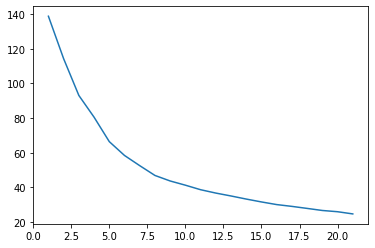

In [618]:
inertia_list = []
for i in range(1,22):
    tvlsakmeans = KMeans(n_clusters=i, random_state=409408).fit(Xtvlsa)
    inertia_list.append(tvlsakmeans.inertia_)
    #print(np.unique(tvlsakmeans.labels_, return_counts=True))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21], inertia_list)

In [743]:
np.unique(tvlsakmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 85,  28,  81, 103,  27]))

In [744]:
tvlsakmeans.labels_

array([3, 2, 3, 3, 3, 3, 0, 0, 0, 2, 3, 3, 1, 2, 2, 0, 3, 3, 3, 3, 2, 1,
       3, 2, 3, 2, 2, 4, 0, 0, 1, 0, 4, 3, 0, 3, 0, 3, 4, 2, 0, 2, 0, 0,
       0, 0, 3, 2, 3, 4, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 0, 3, 3, 3, 0, 1,
       4, 4, 3, 2, 0, 3, 1, 0, 0, 0, 4, 4, 0, 3, 3, 1, 1, 4, 3, 3, 0, 3,
       0, 0, 2, 2, 2, 0, 3, 4, 0, 0, 3, 2, 3, 2, 3, 0, 2, 1, 0, 3, 0, 0,
       2, 4, 0, 0, 0, 2, 3, 3, 1, 0, 0, 3, 0, 3, 4, 2, 2, 2, 2, 2, 2, 0,
       3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 2, 2,
       0, 3, 3, 3, 4, 4, 4, 3, 2, 3, 0, 4, 0, 0, 2, 0, 3, 3, 0, 4, 2, 3,
       2, 3, 0, 2, 0, 0, 2, 0, 3, 3, 3, 1, 2, 1, 1, 2, 4, 4, 4, 2, 3, 0,
       0, 3, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 0, 0, 0, 0, 3, 0, 2, 1, 0, 0,
       0, 4, 0, 2, 3, 3, 1, 0, 3, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 2, 1, 3,
       0, 2, 3, 2, 2, 0, 2, 2, 1, 2, 3, 0, 2, 3, 0, 2, 0, 3, 0, 0, 2, 2,
       1, 0, 3, 0, 2, 2, 1, 3, 1, 3, 0, 2, 0, 0, 1, 0, 0, 2, 3, 0, 2, 2,
       3, 3, 3, 0, 3, 3, 3, 4, 1, 2, 4, 3, 2, 0, 3,

In [730]:
cvlsakmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=493, tol=0.0001, verbose=0)

In [576]:
speeches_raw_no_nouns[9][0:1000]

'- - ACTION Speech The time has come when action rather than speech is required. Eighteen months ago in this I prayed that the responsibility might not fall upon me to ask this country to accept the awful arbitrament of war. I fear that I may not be able to avoid that responsibility. at any rate, I cannot wish for conditions in which such a burden should fall upon me in which I should feel clearer than I do to-day as to where my duty lies. No man can say that the could have done more to try to keep open the way for an honorable and equitable settlement of the dispute between and have we neglected any means of making it crystal clear to the German that if they insisted on using force again in the manner in which they had used it in the past we were resolved to oppose them by force. Now that all the relevant documents are being made public we shall stand at the bar of history knowing that the responsibility for this terrible catastrophe lies on the shoulders of one man - the German who h

to do: textblob sentiment avg/variance by cluster, pyldavis and tsne, 

In [748]:
def speech_cluster_sentiments(speech_data):
    clu0 = []
    clu1 = []
    clu2 = []
    clu3 = []
    clu4 = []
    for idx, speech in enumerate(speeches_no_nouns):
        blob = TextBlob(speech)
        if(tvlsakmeans.labels_[idx] == 0):
            clu0.append(blob.sentiment.polarity)
        if(tvlsakmeans.labels_[idx] == 1):
            clu1.append(blob.sentiment.polarity)
        if(tvlsakmeans.labels_[idx] == 2):
            clu2.append(blob.sentiment.polarity)
        if(tvlsakmeans.labels_[idx] == 3):
            clu3.append(blob.sentiment.polarity)
        if(tvlsakmeans.labels_[idx] == 4):
            clu4.append(blob.sentiment.polarity)
    means = [np.mean(clu0), np.mean(clu1), np.mean(clu2), np.mean(clu3), np.mean(clu4)]
    var = [np.var(clu0), np.var(clu1), np.var(clu2), np.var(clu3), np.var(clu4)]
    for _ in range (0,4):
        print(str(_)+ ' mean:' + str(means[_])+' \tvar: '+str(var[_]))

0 mean:0.12568574930171234 	var: 0.02018963784948604
1 mean:0.12900199277477473 	var: 0.009672156833014338
2 mean:0.14421407284094312 	var: 0.010509442329674212
3 mean:0.15143619891000534 	var: 0.014453917041025945


In [760]:
pyLDAvis.enable_notebook

<function pyLDAvis._display.enable_notebook(local=False, **kwargs)>

In [782]:
vis = pyLDAvis.sklearn.prepare(cvlda, Xc, cvectorizer)
vis

KeyboardInterrupt: 

In [776]:
Xc.shape

(324, 500328)

In [795]:
X_tsne = TSNE(n_components=3, perplexity=50).fit_transform(Xcvlsa)


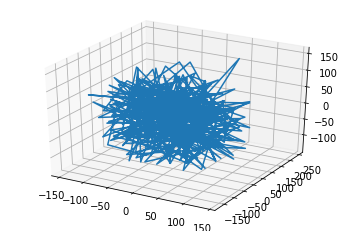

In [797]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D([x[0] for x in X_tsne], [x[1] for x in X_tsne], [x[2] for x in X_tsne])

gensim testing

In [799]:
nltk.download('stopwords')
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to /Users/local/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     |████████████████████████████████| 11.1MB 6.9MB/s eta 0:00:01    |███████▎                        | 2.5MB 605kB/s eta 0:00:15     |███████████████████▋            | 6.8MB 186kB/s eta 0:00:24
  Stored in directory: /private/var/folders/dz/tbfqwgn97dvgxvxjn412x47m0000gn/T/pip-ephem-wheel-cache-_t2dfkc2/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/en_core_web_sm -->
/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [804]:
stop_words = stopwords.words('english')
#stop_words.extend(['people', 'said'])

In [806]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

speeches_tokenized = list(sent_to_words(speeches_raw))

In [814]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

speeches_words_no_stops = remove_stopwords(speeches_tokenized)
nlp = spacy.load('en', disable=['parser', 'ner'])
speeches_lemmatized = lemmatization(speeches_words_no_stops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [815]:
id2word = corpora.Dictionary(speeches_lemmatized)
texts = speeches_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 6), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 6), (7, 4), (8, 1), (9, 1), (10, 1), (11, 1), (12, 6), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 4), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 3), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 2), (91, 3), (92, 1), (93, 1), (94, 3), (95, 1), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 2), (108, 1), (109, 1), (110, 1)

In [822]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [823]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"te" + 0.006*"ad" + 0.005*"cf" + 0.004*"qui" + 0.004*"esse" + '
  '0.004*"quod" + 0.004*"cum" + 0.004*"non" + 0.003*"quid" + 0.003*"die"'),
 (1,
  '0.015*"woman" + 0.014*"state" + 0.013*"right" + 0.009*"government" + '
  '0.009*"man" + 0.008*"law" + 0.007*"may" + 0.007*"country" + 0.006*"make" + '
  '0.006*"power"'),
 (2,
  '0.009*"ethiopia" + 0.002*"anc" + 0.002*"johannesburg" + 0.002*"township" + '
  '0.002*"tanganyika" + 0.001*"sharpeville" + 0.001*"mozambique" + '
  '0.001*"sizwe" + 0.001*"transkei" + 0.001*"tshombe"'),
 (3,
  '0.017*"people" + 0.014*"world" + 0.012*"nation" + 0.010*"country" + '
  '0.009*"government" + 0.008*"freedom" + 0.006*"war" + 0.006*"year" + '
  '0.006*"today" + 0.005*"german"'),
 (4,
  '0.009*"must" + 0.008*"people" + 0.008*"work" + 0.008*"good" + '
  '0.007*"american" + 0.007*"make" + 0.007*"life" + 0.007*"great" + '
  '0.006*"year" + 0.006*"new"'),
 (5,
  '0.035*"war" + 0.020*"peace" + 0.015*"nation" + 0.010*"world" + 0.010*"army" '
  '+ 0.

In [824]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(model=lda_model, texts=speeches_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.286209866302467

Coherence Score:  0.42855886199391213


In [828]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.182691 -0.046519       1        1  28.507965
4     -0.226466  0.042436       2        1  23.052303
8     -0.180228  0.094810       3        1  22.085228
3     -0.193369 -0.110230       4        1  13.916260
9     -0.110636  0.255518       5        1   6.332090
5     -0.114007 -0.230936       6        1   5.168945
0      0.296528  0.000476       7        1   0.901055
2      0.238666 -0.001578       8        1   0.028313
7      0.236410 -0.001981       9        1   0.007268
6      0.235792 -0.001996      10        1   0.000571, topic_info=      Category         Freq             Term        Total  loglift  logprob
202    Default  1558.000000              war  1558.000000  30.0000  30.0000
692    Default  2469.000000              say  2469.000000  29.0000  29.0000
87     Default  1733.000000               go  1733.000000  28.0000  28.0000
85     Default  1048.000000              get  1048.000000  27.0000  27.0000
521    Default  3976.000000              man  3976.000000  26.0000  26.0000
479    Default  1746.000000             know  1746.000000  25.0000  25.0000
135    Default  1176.000000            peace  1176.000000  24.0000  24.0000
124    Default  2130.000000           nation  2130.000000  23.0000  23.0000
136    Default  3208.000000           people  3208.000000  22.0000  22.0000
679    Default  2328.000000            right  2328.000000  21.0000  21.0000
798    Default   687.000000            white   687.000000  20.0000  20.0000
210    Default  1966.000000            world  1966.000000  19.0000  19.0000
207    Default  2175.000000            woman  2175.000000  18.0000  18.0000
32     Default  1527.000000             come  1527.000000  17.0000  17.0000
751    Default   830.000000             tell   830.000000  16.0000  16.0000
201    Default   970.000000             want   970.000000  15.0000  15.0000
523    Default  2006.000000              may  2006.000000  14.0000  14.0000
418    Default   782.000000            force   782.000000  13.0000  13.0000
732    Default  2283.000000            state  2283.000000  12.0000  12.0000
1536   Default   413.000000            black   413.000000  11.0000  11.0000
90     Default  2081.000000       government  2081.000000  10.0000  10.0000
1771   Default   502.000000           german   502.000000   9.0000   9.0000
553    Default   345.000000            negro   345.000000   8.0000   8.0000
88     Default   794.000000              god   794.000000   7.0000   7.0000
809    Default  1646.000000             year  1646.000000   6.0000   6.0000
707    Default  1116.000000            shall  1116.000000   5.0000   5.0000
792    Default   547.000000             vote   547.000000   4.0000   4.0000
761    Default   987.000000            thing   987.000000   3.0000   3.0000
1496   Default   313.000000             army   313.000000   2.0000   2.0000
109    Default  1260.000000              law  1260.000000   1.0000   1.0000
...        ...          ...              ...          ...      ...      ...
6929   Topic10     0.000116       refutation     0.724686   3.3304  -9.9456
4441   Topic10     0.000116             dial     0.724708   3.3304  -9.9456
4458   Topic10     0.000116       feebleness     0.724708   3.3304  -9.9456
6944   Topic10     0.000116          stoutly     0.724686   3.3304  -9.9456
6948   Topic10     0.000116           thetis     0.724686   3.3304  -9.9456
20859  Topic10     0.000116              woz     0.741508   3.3075  -9.9456
6965   Topic10     0.000116             zeus     0.725802   3.3289  -9.9456
6947   Topic10     0.000116          theatre    11.972559   0.5258  -9.9456
6949   Topic10     0.000116          trainer     0.725802   3.3289  -9.9456
6950   Topic10     0.000116             troy     4.065262   1.6059  -9.9456
6951   Topic10     0.000116      unconscious     9.650694   0.7414  -9.9456
6952   Topic10     0.000116      unfortun

In [827]:
pyLDAvis.display(vis)

TypeError: Object of type 'complex' is not JSON serializable

In [775]:
import gensim
dictionary = gensim.corpora.Dictionary.load('newsgroups.dict')
corpus = gensim.corpora.MmCorpus('newsgroups.mm')
lda = gensim.models.ldamodel.LdaModel.load('newsgroups_50.model')


/Users/local/anaconda3/envs/metis/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


FileNotFoundError: [Errno 2] No such file or directory: 'newsgroups.dict'